In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
from astropy.table import Table, join
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.spatial import cKDTree

In [2]:
initial_values = Table.read('../spectrum_analysis/galah_dr4_initial_parameters_220714_lite.fits')

In [3]:
grids = Table.read('galah_dr4_model_trainingset_gridpoints.fits')

In [4]:
grids['model_name'] = np.array([str(int(grid['teff_subgrid']))+'_'+str("{:.2f}".format(grid['logg_subgrid']))+'_'+str("{:.2f}".format(grid['fe_h_subgrid'])) for grid in grids])

In [5]:
grid_index_tree = cKDTree(np.c_[grids['teff_subgrid']/1000.,grids['logg_subgrid'],grids['fe_h_subgrid']])

In [6]:
initial_values['grid_index'] = np.array([grid_index_tree.query([tgf[0]/1000.,tgf[1],tgf[2]]) for tgf in np.array([initial_values['teff'],initial_values['logg'],initial_values['fe_h']]).T])[:,1]

In [7]:
indices = initial_values['grid_index']
priority = Table()
d,c = np.unique(indices, return_counts=True)
priority['index_subgrid'] = np.array(d,dtype=int)
priority['counts_dr4_init'] = np.array(c,dtype=int)
priority = join(priority, grids, keys='index_subgrid')
priority.sort(keys='counts_dr4_init',reverse=True)

In [8]:
def test_grid_index_computations(test_grid_index = 1931, print_all_points=False,):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -0.75:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_done:
                        if t[0] not in grids_started:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                            else:
                                print(str(t[0])+',')
                        else:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already started')
                    else:
                        if print_all_points:
                            print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    

In [9]:
def test_grid_index_ready_for_training(test_grid_index = 1931, print_all_points=False,):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -0.75:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_converted_to_nn_input:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' not ready')
                    else:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    

In [59]:
grids_started = [
1245,
1257,
1269,
1354,
1457,
1460,
1506,
1507,
1508,
1563,
1609,
1610,
1611,
1684,
1685,
1686,
1698,
1710,
]

In [60]:
grids_done = [
    1242,1243,1244,
    1254,1255,1256,
    1266,1267,1268,
    1351,1352,1353,
    1363,1364,1365,1366,
    1375,1376,1377,1378,
    1387,1388,1389,1390,
    1458,1459,
    1469,
    1470,1471,1472,
    1481,1482,1483,1484,
    1493,1494,1495,1496,
    1560,1561,1562,
    1572,1573,1574,1575,
    1584,1585,1586,1587,
    1596,1597,1598,1599,
    1695,1696,1697,
    1707,1708,1709,
    1719,1720,1721,
    1724,1725,1726,1727,1728,
    1736,1737,1738,1739,1740,   
    1748,1749,
    1750,1751,1752,
    1790,1791,1792,
    1802,1803,1804,
    1814,1815,1816,
    1819,
    1820,1821,1822,1823,
    1831,1832,1833,1834,1835,
    1843,1844,1845,1846,1847,
    1876,1877,1878,
    1888,1889,
    1890,
    1900,1901,1902,
    1905,1906,1907,1908,1909,
    1917,1918,1919,
    1920,1921,
    1929,
    1930,1931,1932,1933,
    1988,1989,
    1990,1991,1992,
    2000,2001,2002,2003,2004,
    2012,2013,2014,2015,2016,
    2065,2066,2067,2068,2069,
    2077,2078,2079,
    2080,2081,
    2089,
    2090,2091,2092,2093,
]
print(len(grids_done),len(grids_done) * 280)

155 43400


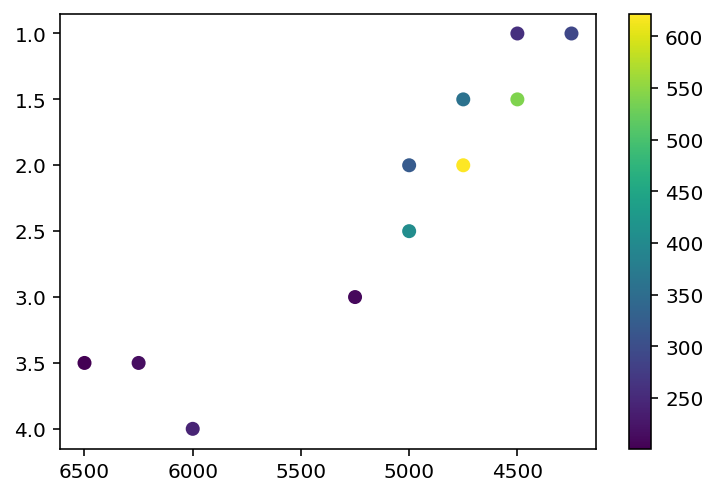

[1483, 1365, 1598, 1471, 1586, 1244, 1353, 1997, 2062, 1709, 2135]


index_subgrid,counts_dr4_init,teff_subgrid,teff_low_subgrid,teff_high_subgrid,logg_subgrid,logg_low_subgrid,logg_high_subgrid,fe_h_subgrid,fe_h_low_subgrid,fe_h_high_subgrid,random_seed_subgrid,model_name
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str15
1483,622,4750.0,4500.0,5000.0,2.0,1.5,2.5,-1.5,-2.0,-1.0,4620,4750_2.00_-1.50
1365,541,4500.0,4250.0,4750.0,1.5,1.0,2.0,-1.5,-2.0,-1.0,4365,4500_1.50_-1.50
1598,406,5000.0,4750.0,5250.0,2.5,2.0,3.0,-1.5,-2.0,-1.0,4875,5000_2.50_-1.50
1471,360,4750.0,4500.0,5000.0,1.5,1.0,2.0,-1.5,-2.0,-1.0,4615,4750_1.50_-1.50
1586,321,5000.0,4750.0,5250.0,2.0,1.5,2.5,-1.5,-2.0,-1.0,4870,5000_2.00_-1.50
1244,290,4250.0,4000.0,4500.0,1.0,0.5,1.5,-1.5,-2.0,-1.0,4110,4250_1.00_-1.50
1353,260,4500.0,4250.0,4750.0,1.0,0.5,1.5,-1.5,-2.0,-1.0,4360,4500_1.00_-1.50
1997,243,6000.0,5750.0,6250.0,4.0,3.5,4.5,-1.5,-2.0,-1.0,5890,6000_4.00_-1.50
2062,216,6250.0,6000.0,6500.0,3.5,3.0,4.0,-1.5,-2.0,-1.0,6135,6250_3.50_-1.50


In [61]:
# selection = (priority['fe_h_subgrid'] <= -2) & (priority['counts_dr4_init'] > 200)
selection = (priority['fe_h_subgrid'] > - 2) & (priority['fe_h_subgrid'] <= -1.5) & (priority['counts_dr4_init'] > 200)

f, ax = plt.subplots()
s = ax.scatter(
    priority['teff_subgrid'][selection],
    priority['logg_subgrid'][selection],
    c = priority['counts_dr4_init'][selection],
)
plt.colorbar(s, ax=ax)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()
plt.close()

print(list(priority['index_subgrid'][selection]))

priority[selection]

In [69]:
# ALREADY DONE
selection = [
    1364,1365,
    1470,1471,
    1482, 1483,
    1598,
    1803,
    2002, 2001, 1919, 1918, 1931, 1920, 1845, 1930, 1833, 2014, 1844, 2003, 2013, 1932, 1832, 1834, 1846, 2015
]
selection = [1586,]# ] 1244, 1353, 1997, 2062, 1709, 2135

for t in selection:
    test_grid_index_computations(t)

1672,
1673,
1674,


In [70]:
all_around = np.unique([
])
all_around,len(all_around)

(array([], dtype=float64), 0)

In [71]:
grids_converted_to_nn_input = [
    1242,1243,1244,
    1254,1255,1256,
    1266,1267,1268,    
    1351,1352,1353,
    1363,1364,1365,
    1375,1376,1377,
    1387,1388,1389,
    1469,
    1470,1471,
    1481,1482,1483,
    1493,1494,1495,
    1572,1573,1574,
    1584,1585,1586,
    1596,1597,1598,
    1724,1725,1726,1727,1728,
    1736,1737,1738,1739,1740,
    1748,1749,
    1750,1751,1752,
    1819,1820,1821,1822,1823,
    1831,1832,1833,1834,1835,
    1843,1844,1845,1846,1847,
    1905,1906,1907,1908,1909,
    1917,1918,1919,
    1920,1921,
    1929,1930,1931,1932,1933,
    1988,1989,1990,1991,1992,
    2000,2001,2002,2003,2004,
    2012,2013,2014,2015,2016,
    2065,2066,2067,2068,2069,
    2077,2078,2079,
    2080,2081,
    2089,
    2090,2091,2092,2093,
]
print(len(grids_converted_to_nn_input))

114


In [75]:
test_grid_index_ready_for_training(test_grid_index = 1932)

1833 5500_4.00_0.00  done
1834 5500_4.00_0.25  done
1835 5500_4.00_0.50  done
1845 5500_4.50_0.00  done
1846 5500_4.50_0.25  done
1847 5500_4.50_0.50  done
1919 5750_4.00_0.00  done
1920 5750_4.00_0.25  done
1921 5750_4.00_0.50  done
1931 5750_4.50_0.00  done
1932 5750_4.50_0.25  done
1933 5750_4.50_0.50  done
2002 6000_4.00_0.00  done
2003 6000_4.00_0.25  done
2004 6000_4.00_0.50  done
2014 6000_4.50_0.00  done
2015 6000_4.50_0.25  done
2016 6000_4.50_0.50  done


In [37]:
trained_3x3x3 = [
# CURRENT GRID
#     1482, # Training with 10002 spectra (89%), Testing with 1112 spectra (10%), 9663.655 validation loss = 9652.573
    1931,
    2001, # Training with 12441 spectra (89%), Testing with 1383 spectra (10%), 9266.918 validation loss = 9256.894, 21.200 validation loss = 21.490
    2002,
]

In [38]:
s = []
for grid_p in grids_done:
    if grid_p not in grids_converted_to_nn_input:
        print(str(grid_p)+',')
        s.append(grid_p)
print(len(s))
print('import os')
print('ps = ['+','.join([str(x) for x in s])+']')
print('for p in ps:')
print("    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))")

1366,
1378,
1390,
1458,
1459,
1472,
1484,
1496,
1560,
1561,
1562,
1575,
1587,
1599,
1695,
1696,
1697,
1707,
1708,
1709,
1719,
1720,
1721,
1790,
1791,
1792,
1802,
1803,
1804,
1814,
1815,
1816,
1876,
1877,
1878,
1888,
1889,
1890,
1900,
1901,
1902,
41
import os
ps = [1366,1378,1390,1458,1459,1472,1484,1496,1560,1561,1562,1575,1587,1599,1695,1696,1697,1707,1708,1709,1719,1720,1721,1790,1791,1792,1802,1803,1804,1814,1815,1816,1876,1877,1878,1888,1889,1890,1900,1901,1902]
for p in ps:
    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))


In [ ]:
# Currently converting
# t1: 1366,1378,1390,1458,1459,1472,1484,1496,1560
# t2: 1561,1562,1575,1587,1599,1695,1696,1697,1707

In [40]:
def get_progress():
    progress_table = Table()
    progress_table['index_subgrid'] = grids['index_subgrid']
    # Let's get placeholders for the important progress indicators: nr grids calculated, nr grids converted into training_data, training_fully finished
    progress_table['trainingset_done'] = np.zeros(len(grids['index_subgrid']),dtype=int)
    progress_table['grids_trainingset'] = np.zeros(len(grids['index_subgrid']),dtype=int)
    progress_table['grids_calculated'] = np.zeros(len(grids['index_subgrid']),dtype=int)
    progress_table['next_conversion'] = np.zeros(len(grids['index_subgrid']),dtype=int)
    progress_table['next_calculation'] = np.zeros(len(grids['index_subgrid']),dtype=int)
    # Convert all 7 grids to their gridnames
    progress_table['grid_1'] = np.array([str(int(grids['teff_subgrid'][x]))+'_'+"{:.2f}".format(grids['logg_subgrid'][x])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][x]) for x in range(len(grids['index_subgrid']))])
    progress_table['grid_2'] = np.array([str(int(grids['teff_low_subgrid'][x]))+'_'+"{:.2f}".format(grids['logg_subgrid'][x])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][x]) for x in range(len(grids['index_subgrid']))])
    progress_table['grid_3'] = np.array([str(int(grids['teff_high_subgrid'][x]))+'_'+"{:.2f}".format(grids['logg_subgrid'][x])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][x]) for x in range(len(grids['index_subgrid']))])
    progress_table['grid_4'] = np.array([str(int(grids['teff_subgrid'][x]))+'_'+"{:.2f}".format(grids['logg_low_subgrid'][x])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][x]) for x in range(len(grids['index_subgrid']))])
    progress_table['grid_5'] = np.array([str(int(grids['teff_subgrid'][x]))+'_'+"{:.2f}".format(grids['logg_high_subgrid'][x])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][x]) for x in range(len(grids['index_subgrid']))])
    progress_table['grid_6'] = np.array([str(int(grids['teff_subgrid'][x]))+'_'+"{:.2f}".format(grids['logg_subgrid'][x])+'_'+"{:.2f}".format(grids['fe_h_low_subgrid'][x]) for x in range(len(grids['index_subgrid']))])
    progress_table['grid_7'] = np.array([str(int(grids['teff_subgrid'][x]))+'_'+"{:.2f}".format(grids['logg_subgrid'][x])+'_'+"{:.2f}".format(grids['fe_h_high_subgrid'][x]) for x in range(len(grids['index_subgrid']))])
    # Now let's set zeros for the progress to initiate
    progress_table['grid_1_calculated'] = np.zeros(len(grids['index_subgrid']))
    progress_table['grid_2_calculated'] = np.zeros(len(grids['index_subgrid']))
    progress_table['grid_3_calculated'] = np.zeros(len(grids['index_subgrid']))
    progress_table['grid_4_calculated'] = np.zeros(len(grids['index_subgrid']))
    progress_table['grid_5_calculated'] = np.zeros(len(grids['index_subgrid']))
    progress_table['grid_6_calculated'] = np.zeros(len(grids['index_subgrid']))
    progress_table['grid_7_calculated'] = np.zeros(len(grids['index_subgrid']))
    # Let's see which ones we have already put into a training set
    progress_table['grid_1_trainingset'] = np.zeros(len(grids['index_subgrid']))
    progress_table['grid_2_trainingset'] = np.zeros(len(grids['index_subgrid']))
    progress_table['grid_3_trainingset'] = np.zeros(len(grids['index_subgrid']))
    progress_table['grid_4_trainingset'] = np.zeros(len(grids['index_subgrid']))
    progress_table['grid_5_trainingset'] = np.zeros(len(grids['index_subgrid']))
    progress_table['grid_6_trainingset'] = np.zeros(len(grids['index_subgrid']))
    progress_table['grid_7_trainingset'] = np.zeros(len(grids['index_subgrid']))
    # Some grids cannot be calculated, let's set their value to 1 already
    # For example, we do not have grids with 5.0 logg for Teff > 4000
    progress_table['grid_5_calculated'][np.where((grids['teff_subgrid'] > 4000) & (grids['logg_high_subgrid'] > 4.75))[0]] = 1
    progress_table['grid_5_trainingset'][np.where((grids['teff_subgrid'] > 4000) & (grids['logg_high_subgrid'] > 4.75))[0]] = 1
    # Then go through the list of the ones that we actually have calculated
    for grid_done in grids_done:
        that_grid = progress_table['grid_1'][grid_done]
        try:
            progress_table['grid_1_calculated'][np.where(progress_table['grid_1'] == that_grid)[0][0]] = 1
        except:
            pass
        try:
            progress_table['grid_2_calculated'][np.where(progress_table['grid_2'] == that_grid)[0][0]] = 1
        except:
            pass
        try:
            progress_table['grid_3_calculated'][np.where(progress_table['grid_3'] == that_grid)[0][0]] = 1
        except:
            pass
        try:
            progress_table['grid_4_calculated'][np.where(progress_table['grid_4'] == that_grid)[0][0]] = 1
        except:
            pass
        try:
            progress_table['grid_5_calculated'][np.where(progress_table['grid_5'] == that_grid)[0][0]] = 1
        except:
            pass
        try:
            progress_table['grid_6_calculated'][np.where(progress_table['grid_6'] == that_grid)[0][0]] = 1
        except:
            pass
        try:
            progress_table['grid_7_calculated'][np.where(progress_table['grid_7'] == that_grid)[0][0]] = 1
        except:
            pass
    # Then go through the list of the ones that we actually have transformed into a training_data
    for grid_done in grids_converted_to_nn_input:
        that_grid = progress_table['grid_1'][grid_done]
        try:
            progress_table['grid_1_trainingset'][np.where(progress_table['grid_1'] == that_grid)[0][0]] = 1
        except:
            pass
        try:
            progress_table['grid_2_trainingset'][np.where(progress_table['grid_2'] == that_grid)[0][0]] = 1
        except:
            pass
        try:
            progress_table['grid_3_trainingset'][np.where(progress_table['grid_3'] == that_grid)[0][0]] = 1
        except:
            pass
        try:
            progress_table['grid_4_trainingset'][np.where(progress_table['grid_4'] == that_grid)[0][0]] = 1
        except:
            pass
        try:
            progress_table['grid_5_trainingset'][np.where(progress_table['grid_5'] == that_grid)[0][0]] = 1
        except:
            pass
        try:
            progress_table['grid_6_trainingset'][np.where(progress_table['grid_6'] == that_grid)[0][0]] = 1
        except:
            pass
        try:
            progress_table['grid_7_trainingset'][np.where(progress_table['grid_7'] == that_grid)[0][0]] = 1
        except:
            pass
    progress_table['grids_calculated'] = np.sum(progress_table['grid_'+str(n)+'_calculated'] for n in [1,2,3,4,5,6,7])
    progress_table['grids_trainingset'] = np.sum(progress_table['grid_'+str(n)+'_trainingset'] for n in [1,2,3,4,5,6,7])
    for index in trained_3x3x3:
        progress_table['trainingset_done'][index] = 1
    for index in range(len(progress_table['grids_trainingset'])):
        if progress_table['grids_calculated'][index] == 6:
            missing_grid = np.where(np.array([progress_table['grid_'+str(n)+'_calculated'][index] for n in [1,2,3,4,5,6,7]])==0)[0][0]
            index_missing_grid = np.where(progress_table['grid_1'] == progress_table['grid_'+str(missing_grid+1)][index])[0]
            if len(index_missing_grid) > 0:
                index_missing_grid = index_missing_grid[0]
            else:
                index_missing_grid = -1
            progress_table['next_calculation'][index] = index_missing_grid
        if progress_table['grids_calculated'][index] == 5:
            missing_grid = np.where(np.array([progress_table['grid_'+str(n)+'_calculated'][index] for n in [1,2,3,4,5,6,7]])==0)[0][0]
            index_missing_grid = np.where(progress_table['grid_1'] == progress_table['grid_'+str(missing_grid+1)][index])[0]
            if len(index_missing_grid) > 0:
                index_missing_grid = index_missing_grid[0]
            else:
                index_missing_grid = -1
            progress_table['next_calculation'][index] = index_missing_grid
        if progress_table['grids_calculated'][index] == 4:
            missing_grid = np.where(np.array([progress_table['grid_'+str(n)+'_calculated'][index] for n in [1,2,3,4,5,6,7]])==0)[0][0]
            index_missing_grid = np.where(progress_table['grid_1'] == progress_table['grid_'+str(missing_grid+1)][index])[0]
            if len(index_missing_grid) > 0:
                index_missing_grid = index_missing_grid[0]
            else:
                index_missing_grid = -1
            progress_table['next_calculation'][index] = index_missing_grid
        if progress_table['grids_calculated'][index] == 3:
            missing_grid = np.where(np.array([progress_table['grid_'+str(n)+'_calculated'][index] for n in [1,2,3,4,5,6,7]])==0)[0][0]
            index_missing_grid = np.where(progress_table['grid_1'] == progress_table['grid_'+str(missing_grid+1)][index])[0]
            if len(index_missing_grid) > 0:
                index_missing_grid = index_missing_grid[0]
            else:
                index_missing_grid = -1
            progress_table['next_calculation'][index] = index_missing_grid
        if progress_table['grids_calculated'][index] == 2:
            missing_grid = np.where(np.array([progress_table['grid_'+str(n)+'_calculated'][index] for n in [1,2,3,4,5,6,7]])==0)[0][0]
            index_missing_grid = np.where(progress_table['grid_1'] == progress_table['grid_'+str(missing_grid+1)][index])[0]
            if len(index_missing_grid) > 0:
                index_missing_grid = index_missing_grid[0]
            else:
                index_missing_grid = -1
            progress_table['next_calculation'][index] = index_missing_grid
        if progress_table['grids_calculated'][index] == 1:
            missing_grid = np.where(np.array([progress_table['grid_'+str(n)+'_calculated'][index] for n in [1,2,3,4,5,6,7]])==0)[0][0]
            index_missing_grid = np.where(progress_table['grid_1'] == progress_table['grid_'+str(missing_grid+1)][index])[0]
            if len(index_missing_grid) > 0:
                index_missing_grid = index_missing_grid[0]
            else:
                index_missing_grid = -1
            progress_table['next_calculation'][index] = index_missing_grid

    for index in range(len(progress_table['grids_trainingset'])):
        if progress_table['grids_trainingset'][index] == 6:
            missing_grid = np.where(np.array([progress_table['grid_'+str(n)+'_trainingset'][index] for n in [1,2,3,4,5,6,7]])==0)[0][0]
            index_missing_grid = np.where(progress_table['grid_1'] == progress_table['grid_'+str(missing_grid+1)][index])[0]
            if len(index_missing_grid) > 0:
                index_missing_grid = index_missing_grid[0]
            else:
                index_missing_grid = -1
            progress_table['next_conversion'][index] = index_missing_grid
        if progress_table['grids_trainingset'][index] == 5:
            missing_grid = np.where(np.array([progress_table['grid_'+str(n)+'_trainingset'][index] for n in [1,2,3,4,5,6,7]])==0)[0][0]
            index_missing_grid = np.where(progress_table['grid_1'] == progress_table['grid_'+str(missing_grid+1)][index])[0]
            if len(index_missing_grid) > 0:
                index_missing_grid = index_missing_grid[0]
            else:
                index_missing_grid = -1
            progress_table['next_conversion'][index] = index_missing_grid
        if progress_table['grids_trainingset'][index] == 4:
            missing_grid = np.where(np.array([progress_table['grid_'+str(n)+'_trainingset'][index] for n in [1,2,3,4,5,6,7]])==0)[0][0]
            index_missing_grid = np.where(progress_table['grid_1'] == progress_table['grid_'+str(missing_grid+1)][index])[0]
            if len(index_missing_grid) > 0:
                index_missing_grid = index_missing_grid[0]
            else:
                index_missing_grid = -1
            progress_table['next_conversion'][index] = index_missing_grid

    return(progress_table)
progress_table = get_progress()
x=90
progress_table[np.where((progress_table['grids_calculated'] >= 6) & (progress_table['trainingset_done'] != 1))[0]][x:15+x]

<ipython-input-40-950804f7f776>:100: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  progress_table['grids_calculated'] = np.sum(progress_table['grid_'+str(n)+'_calculated'] for n in [1,2,3,4,5,6,7])
<ipython-input-40-950804f7f776>:101: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  progress_table['grids_trainingset'] = np.sum(progress_table['grid_'+str(n)+'_trainingset'] for n in [1,2,3,4,5,6,7])


index_subgrid,trainingset_done,grids_trainingset,grids_calculated,next_conversion,next_calculation,grid_1,grid_2,grid_3,grid_4,grid_5,grid_6,grid_7,grid_1_calculated,grid_2_calculated,grid_3_calculated,grid_4_calculated,grid_5_calculated,grid_6_calculated,grid_7_calculated,grid_1_trainingset,grid_2_trainingset,grid_3_trainingset,grid_4_trainingset,grid_5_trainingset,grid_6_trainingset,grid_7_trainingset
int64,int64,float64,float64,int64,int64,str15,str15,str15,str16,str15,str15,str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [41]:
print(len(np.unique(list(progress_table['next_calculation'][np.where((progress_table['grids_calculated'] >= 6) & (progress_table['trainingset_done'] != 1))[0]]))))
np.unique(list(progress_table['next_calculation'][np.where((progress_table['grids_calculated'] >= 6) & (progress_table['trainingset_done'] != 1))[0]]))

53


array([   0, 1133, 1340, 1362, 1374, 1480, 1485, 1506, 1507, 1609, 1610,
       1638, 1639, 1640, 1650, 1651, 1652, 1672, 1673, 1684, 1685, 1779,
       1801, 1805, 1808, 1809, 1810, 1827, 1830, 1836, 1842, 1848, 1894,
       1895, 1896, 1916, 1922, 1928, 1934, 1972, 1977, 1978, 1979, 1999,
       2005, 2011, 2017, 2151, 2152, 2153, 2163, 2164, 2165])

In [42]:
progress_table[np.where((progress_table['grids_calculated'] == 7) & (progress_table['trainingset_done'] != 1))[0]]

index_subgrid,trainingset_done,grids_trainingset,grids_calculated,next_conversion,next_calculation,grid_1,grid_2,grid_3,grid_4,grid_5,grid_6,grid_7,grid_1_calculated,grid_2_calculated,grid_3_calculated,grid_4_calculated,grid_5_calculated,grid_6_calculated,grid_7_calculated,grid_1_trainingset,grid_2_trainingset,grid_3_trainingset,grid_4_trainingset,grid_5_trainingset,grid_6_trainingset,grid_7_trainingset
int64,int64,float64,float64,int64,int64,str15,str15,str15,str16,str15,str15,str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1364,0,7.0,7.0,0,0,4500_1.50_-2.00,4250_1.50_-2.00,4750_1.50_-2.00,4500_1.00_-2.00,4500_2.00_-2.00,4500_1.50_-2.50,4500_1.50_-1.50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1365,0,6.0,7.0,1366,0,4500_1.50_-1.50,4250_1.50_-1.50,4750_1.50_-1.50,4500_1.00_-1.50,4500_2.00_-1.50,4500_1.50_-2.00,4500_1.50_-1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1376,0,7.0,7.0,0,0,4500_2.00_-2.00,4250_2.00_-2.00,4750_2.00_-2.00,4500_1.50_-2.00,4500_2.50_-2.00,4500_2.00_-2.50,4500_2.00_-1.50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1377,0,6.0,7.0,1378,0,4500_2.00_-1.50,4250_2.00_-1.50,4750_2.00_-1.50,4500_1.50_-1.50,4500_2.50_-1.50,4500_2.00_-2.00,4500_2.00_-1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1470,0,6.0,7.0,1458,0,4750_1.50_-2.00,4500_1.50_-2.00,5000_1.50_-2.00,4750_1.00_-2.00,4750_2.00_-2.00,4750_1.50_-2.50,4750_1.50_-1.50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1471,0,5.0,7.0,1459,0,4750_1.50_-1.50,4500_1.50_-1.50,5000_1.50_-1.50,4750_1.00_-1.50,4750_2.00_-1.50,4750_1.50_-2.00,4750_1.50_-1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1482,0,7.0,7.0,0,0,4750_2.00_-2.00,4500_2.00_-2.00,5000_2.00_-2.00,4750_1.50_-2.00,4750_2.50_-2.00,4750_2.00_-2.50,4750_2.00_-1.50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1483,0,6.0,7.0,1484,0,4750_2.00_-1.50,4500_2.00_-1.50,5000_2.00_-1.50,4750_1.50_-1.50,4750_2.50_-1.50,4750_2.00_-2.00,4750_2.00_-1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1803,0,0.0,7.0,0,0,5500_3.00_-2.00,5250_3.00_-2.00,5750_3.00_-2.00,5500_2.50_-2.00,5500_3.50_-2.00,5500_3.00_-2.50,5500_3.00_-1.50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
todo = [str(x) for x in progress_table['index_subgrid'][np.where(((progress_table['next_conversion'] == -1) | (progress_table['next_conversion'] == 0)) & (progress_table['grids_calculated'] == 7) & (progress_table['trainingset_done'] != 1))[0]]]
todo1 = todo[:int(len(todo)/2)]
todo2 = todo[int(len(todo)/2):]

print(','.join(todo))
for t in [todo1,todo2]:
    print('import os')
    print('ps = ['+','.join(t)+']')
    print('for p in ps:')
    print("    os.system('ipython galah_dr4_thepayne_grid_interpolation_training_extra6.py '+str(p))")


1364,1376,1482,1803,1832,1833,1834,1844,1845,1846,1918,1919,1920,1930,1932,2003,2013,2014,2015
import os
ps = [1364,1376,1482,1803,1832,1833,1834,1844,1845]
for p in ps:
    os.system('ipython galah_dr4_thepayne_grid_interpolation_training_extra6.py '+str(p))
import os
ps = [1846,1918,1919,1920,1930,1932,2003,2013,2014,2015]
for p in ps:
    os.system('ipython galah_dr4_thepayne_grid_interpolation_training_extra6.py '+str(p))


In [44]:
upcoming_priority = priority[[x not in trained_3x3x3 for x in priority['index_subgrid']]]
upcoming_priority[0]

index_subgrid,counts_dr4_init,teff_subgrid,teff_low_subgrid,teff_high_subgrid,logg_subgrid,logg_low_subgrid,logg_high_subgrid,fe_h_subgrid,fe_h_low_subgrid,fe_h_high_subgrid,random_seed_subgrid,model_name
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str15
1499,30238,4750.0,4500.0,5000.0,2.5,2.0,3.0,-0.25,-0.5,0.0,4750,4750_2.50_-0.25


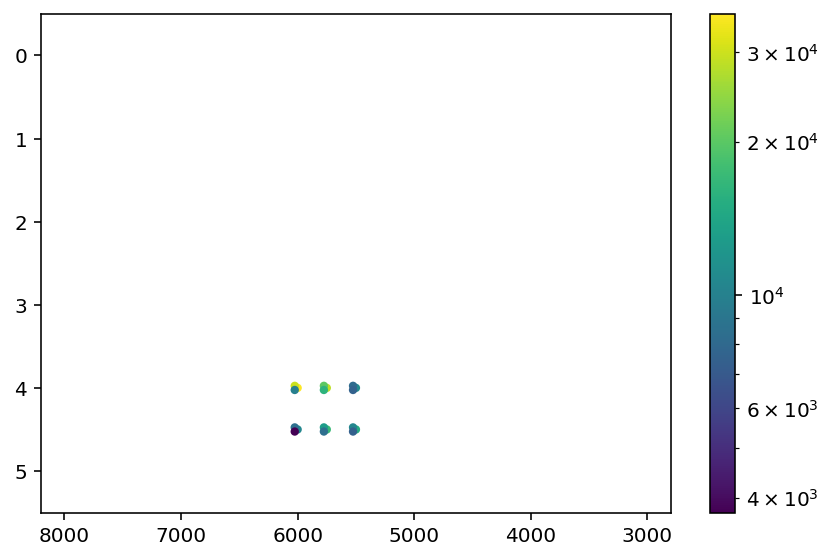

[2002, 2001, 1919, 1918, 1931, 1920, 1845, 1930, 1833, 2014, 1844, 2003, 2013, 1932, 1832, 1834, 1846, 2015]


index_subgrid,counts_dr4_init,teff_subgrid,teff_low_subgrid,teff_high_subgrid,logg_subgrid,logg_low_subgrid,logg_high_subgrid,fe_h_subgrid,fe_h_low_subgrid,fe_h_high_subgrid,random_seed_subgrid,model_name
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str15
2002,35637,6000.0,5750.0,6250.0,4.0,3.5,4.5,0.0,-0.25,0.25,6040,6000_4.00_0.00
2001,29806,6000.0,5750.0,6250.0,4.0,3.5,4.5,-0.25,-0.5,0.0,6015,6000_4.00_-0.25
1919,28433,5750.0,5500.0,6000.0,4.0,3.5,4.5,0.0,-0.25,0.25,5790,5750_4.00_0.00
1918,20179,5750.0,5500.0,6000.0,4.0,3.5,4.5,-0.25,-0.5,0.0,5765,5750_4.00_-0.25
1931,17142,5750.0,5500.0,6000.0,4.5,4.0,5.0,0.0,-0.25,0.25,5795,5750_4.50_0.00
1920,16039,5750.0,5500.0,6000.0,4.0,3.5,4.5,0.25,0.0,0.5,5815,5750_4.00_0.25
1845,15012,5500.0,5250.0,5750.0,4.5,4.0,5.0,0.0,-0.25,0.25,5545,5500_4.50_0.00
1930,13000,5750.0,5500.0,6000.0,4.5,4.0,5.0,-0.25,-0.5,0.0,5770,5750_4.50_-0.25
1833,11056,5500.0,5250.0,5750.0,4.0,3.5,4.5,0.0,-0.25,0.25,5540,5500_4.00_0.00


In [45]:
# selection = (priority['counts_dr4_init'] > 10000)# & (priority['fe_h_subgrid'] < -0.5)
selection = (
    (priority['teff_subgrid'] >= 5500) &
    (priority['teff_subgrid'] <= 6000) &
    (priority['logg_subgrid'] >= 4.0) &
    (priority['logg_subgrid'] <= 5.0) &
    (priority['fe_h_subgrid'] >= -0.25) &
    (priority['fe_h_subgrid'] <= 0.25)
)

f, ax = plt.subplots()
s = ax.scatter(
    priority['teff_subgrid'][selection] + np.abs(100*priority['fe_h_subgrid'][selection]),
    priority['logg_subgrid'][selection] + 0.1*priority['fe_h_subgrid'][selection],
    c = priority['counts_dr4_init'][selection],
    s = 10,
    norm=LogNorm()
)
ax.set_xlim(8200,2800)
ax.set_ylim(5.5,-0.5)
plt.colorbar(s, ax=ax)
plt.tight_layout()
plt.show()
plt.close()
print(list(priority['index_subgrid'][selection]))
priority[selection]